<div align="right">Peter Norvig</div>

# WWW: Who Will Win?

This is a notebook for reasoning about who will win playoff series in basketball (and could be used for other sports). The table of contents for this notebook:

* [Model Discussion](#Models:-Introduction-and-Discussion) What model should I use to make predictions?
* [2019 NBA Playoffs](#2019-NBA-Playoffs) **Will be updated as the playoffs progress.**
* [2018 NBA Playoffs](#2018-NBA-Playoffs) An exciting season.
* [2016 NBA Playoffs](#2016-NBA-Playoffs) Ancient history; sad saga.

---

# Models: Introduction and Discussion

"It's tough to make predictions, especially [about](https://en.wikiquote.org/wiki/Yogi_Berra)  [the](https://en.wikiquote.org/wiki/Niels_Bohr) future." That's true for the NBA basketball playoffs, where there is a wide range of opinions.  Here are some models you might choose to help you make predictions:

1. **Holistic**: I just feel that my favorite team has about a 1 in 5 chance of winning it all.
2. **Game by Game**: I think my team has a 75% chance of winning each game in the first round, then 65% for each game in the second round, but only 45% in the Conference finals, then 55% if they make it to the NBA finals. From that I'll calculate their overall chance.
3. **Point by Point**: My team has a per-game average point differential of +5.79; I'll compare that to the other teams and caclulate overall chances.
4. **Play by Play**: Use [detailed statistics](https://www.basketball-reference.com/play-index/plus/shot_finder.cgi) and overhead video to [model](https://danvatterott.com/blog/2016/06/16/creating-videos-of-nba-action-with-sportsvu-data/) the game shot-by-shot, or even pass-by-pass. Not covered here.

# Point by Point Model

The **[Simple Rating System](https://www.sportingcharts.com/dictionary/nba/simple-rating-system-statistics.aspx) (SRS)** records the average point differential of a team over the season, with a slight adjustment for strength of schedule (see  [basketball-reference.com](https://www.basketball-reference.com/leagues/NBA_2018.html)) . A great team has an SRS around 10; anything over 5 is very good.

The Point-by-Point model says: a game is decided by a random sample from the distribution of point differentials, which is a normal (Gaussian) distribution centered around the difference of SRS scores of the two teams. So, if a team with an SRS of 7 plays an opponent with an SRS of 4, we can expect the team to win by 3, on average, but it will still lose some games. We need to know the standard deviation of the distribution to determine how often that happens; [Betlabs](https://www.betlabssports.com/blog/a-look-at-nba-team-totals/) says the standard deviation 
is 10.5 points across the NBA. 
The function `win_game` does the calculation of win probability given an SRS point differential, using Monte Carlo simulation:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import mean
from random import gauss
from collections import Counter

def win_game(srs_diff, 𝝈=10.5, n=100000):
    "Given SRS point differential of a team against another, return game win probability."
    return mean(gauss(srs_diff, 𝝈) > 0 for game in range(n))

In [2]:
win_game(3)

0.61119

So, if  your team has a 3-point edge over an opponent, this model predicts your team will win 61% of the time.



# Game by Game Model

The next model says that a playoff series is a sequence of independent and identically distributed game results (where the probability of a single-game win could be specified using SRS, or holistically, or some other model). The idea here is to be consistent: if you believe that a team's win percentage is 60%, and you believe that games are independent, then you must believe that the team's chance of wining 4 in a row is 0.6<sup>4</sup> = 0.1296. This model ignores the fact that games aren't strictly independent, ignores the possibility of injuries, and ignores home court advantage. Why? Because these factors would change the final winning estimate by only a few percentage points, and I already have more uncertainty than that.

The function `win_series` calculates the probability of winning a series, given the probability of winning a game:

In [3]:
def win_series(p, W=0, L=0):
    """Probability of winning best-of-7 series, given a probability p of winning a game.
    The optional arguments say how many Wins and Losses the team has in the series so far."""
    return (1 if W == 4 else
            0 if L == 4 else
            p       * win_series(p, W + 1, L) + 
            (1 - p) * win_series(p, W, L + 1))

We can make a table:

In [4]:
for srs_diff in range(10):
    g = win_game(srs_diff)
    print('{} point differential = {:4.0%} win game = {:4.0%} win series'.format(
          srs_diff, g, win_series(g)))

0 point differential =  50% win game =  50% win series
1 point differential =  54% win game =  58% win series
2 point differential =  58% win game =  67% win series
3 point differential =  61% win game =  73% win series
4 point differential =  65% win game =  80% win series
5 point differential =  68% win game =  85% win series
6 point differential =  72% win game =  90% win series
7 point differential =  75% win game =  93% win series
8 point differential =  78% win game =  95% win series
9 point differential =  80% win game =  97% win series


With a zero point differential obviously you're at 50% win percententage; with a 3 point differential you're at 61% to win a game, and 73% to win the series. This agrees very well with the "Differential vs. Win Percentage" [chart](http://a.espncdn.com/combiner/i?img=%2Fphoto%2F2018%2F0408%2F180408_differential.png&w=1140&cquality=40) on [this page](http://www.espn.com/nba/story/_/id/23071005/kevin-pelton-weekly-mailbag-including-nba-all-offensive-teams). 




We can also do plots:

In [5]:
diff = [d/10 for d in range(101)]
game = [win_game(d) for d in diff]
series = [win_series(p) for p in game]

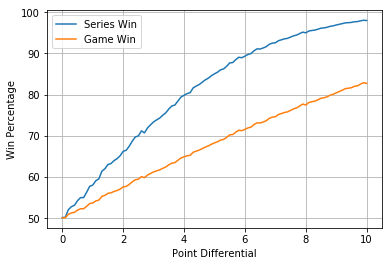

In [6]:
plt.plot(diff, [100*s for s in series], label='Series Win')
plt.plot(diff, [100*g for g in game], label='Game Win')
plt.legend(loc='best'); plt.grid()
plt.xlabel('Point Differential'); plt.ylabel('Win Percentage');

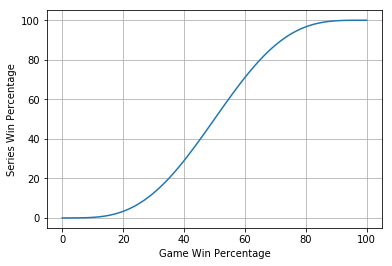

In [7]:
P = range(101)
plt.plot(P, [100*win_series(p/100) for p in P])
plt.grid()
plt.xlabel('Game Win Percentage'); plt.ylabel('Series Win Percentage');

# Series by Series Model

The probability of winning a championship can be modeled by assuming that each series is independent, and multiplying the probability of winning each series. The function `playoffs` does this; it takes as arguments a team name and then some playoff round entries, each consisting of the opponent team name, the game win percentage against this opponent, and optionally the wins and losses in the series so far.

The function `playoffs` does two calculations, one based on my subjective probability of the team winning a single game (as specified in the entry for each round), and one based on the SRS differential. In each line of the output and for each of these two calculations, we show the probability of winning a single game, the probability of winning the series (given that the two teams are still playing), and the probability of winning all the series up to this point.

In [8]:
def playoffs(team, *rounds):
    "Print probability for team winning each series (subjective and SRS)."
    all_p = all_srs = 1.0 # Probabilities of winning it all
    print('{}    {:8} |      Subjective Probabilities  |     SRS Differential'
         .format('Team'.ljust(len(team)), 'Opponent'))
    for (opponent, p, *WL) in rounds:
        p_srs = win_game(SRS[team] - SRS[opponent])
        all_p,   str_p   = update(all_p,   p,     *WL)
        all_srs, str_srs = update(all_srs, p_srs, *WL)
        print('{} vs {:8} | {} |{}'.format(team, opponent, str_p, str_srs))
              
def update(all_p, p, W=0, L=0):
    "Update the probability of winning it all, `all_p`, and also return a string."
    series_p = win_series(p, W, L)
    all_p *= series_p
    return all_p, '{} Game;{} Series;{} All'.format(pct(p), pct(series_p), pct(all_p))

pct = '{:4.0%}'.format 

---
# 2019 NBA Playoffs

## 12 April, 2019

Here are the SRS scores and my subjective ratings for what I consider the two top teams  in 2019, the Warriors and Bucks, and their likely playoff opponents:

In [9]:
SRS = dict(Warriors=6.42, Nuggets=4.19, Rockets=4.96, Clippers=1.09, 
           Bucks=8.04, Raptors=5.49, Sixers=2.25, Celtics=3.90, Pistons=-0.56)

playoffs('Warriors',
         ('Clippers', 0.80),
         ('Rockets',  0.65),
         ('Nuggets',  0.70),
         ('Bucks',    0.52))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Clippers |  80% Game; 97% Series; 97% All | 69% Game; 87% Series; 87% All
Warriors vs Rockets  |  65% Game; 80% Series; 77% All | 56% Game; 62% Series; 54% All
Warriors vs Nuggets  |  70% Game; 87% Series; 68% All | 59% Game; 68% Series; 37% All
Warriors vs Bucks    |  52% Game; 54% Series; 37% All | 44% Game; 37% Series; 13% All


In [10]:
playoffs('Bucks',
         ('Pistons',  0.80),
         ('Celtics',  0.67),
         ('Raptors',  0.60),
         ('Warriors', 0.48))

Team     Opponent |      Subjective Probabilities  |     SRS Differential
Bucks vs Pistons  |  80% Game; 97% Series; 97% All | 79% Game; 96% Series; 96% All
Bucks vs Celtics  |  67% Game; 83% Series; 80% All | 65% Game; 81% Series; 78% All
Bucks vs Raptors  |  60% Game; 71% Series; 57% All | 59% Game; 70% Series; 54% All
Bucks vs Warriors |  48% Game; 46% Series; 26% All | 56% Game; 64% Series; 34% All


So, my subjective probabilities favor the Warriors over the Bucks, 37% to 26%. But the SRS scores disagree, favoring the Bucks 34% to 13%.

Note that [538](https://projects.fivethirtyeight.com/2019-nba-predictions/) has two very different predictions. Their ELO model (similar to SRS) has the Bucks as favorites with a 23% chance of winning, with the Warriors and Rockets next at 16% each. But their CARMELO model has the Warriors with a staggering 61% chance, followed by the Raptors at 16% and the Bucks at 15%.

I have low confidence in the [SRS ratings](https://www.basketball-reference.com/leagues/NBA_2019.html), because the Warriors seemed like they were coasting for parts of the regular season and are capable of "flipping the switch" in the playoffs, and because the Bucks have significant injuries to Brogdon, Mirotic and Gasol, all of whom contributed to the Bucks' great record in the season but will miss parts of the playoffs.

---

# 2018 NBA Playoffs

## 12 April, 2018

The Las Vegas oddsmakers  have the Warriors and Rockers as co-favorites at 35% chance to win the title, while  [538](https://fivethirtyeight.com/features/the-nba-playoffs-sleepers-favorites-and-best-first-round-matchups/), using their CARM-ELO model, favor the Rockets at 44% and give the Warriors only a 4% chance. Those big differences underscore that rational people can use different models with different assumptions and come to different conclusions.  

In [11]:
SRS = dict(Raptors=7.29, Celtics=3.23, Sixers=4.30, Cavs=0.59, Rockets=8.21, Warriors=5.79, 
           Blazers=2.60, Thunder=3.42, Jazz=4.47, Spurs=2.89, Wolves=2.35)

In [12]:
playoffs('Rockets',
         ('Wolves',   0.75),
         ('Jazz',     0.70),
         ('Warriors', 0.55),
         ('Raptors',  0.60))

Team       Opponent |      Subjective Probabilities  |     SRS Differential
Rockets vs Wolves   |  75% Game; 93% Series; 93% All | 71% Game; 89% Series; 89% All
Rockets vs Jazz     |  70% Game; 87% Series; 81% All | 64% Game; 78% Series; 70% All
Rockets vs Warriors |  55% Game; 61% Series; 49% All | 59% Game; 69% Series; 48% All
Rockets vs Raptors  |  60% Game; 71% Series; 35% All | 53% Game; 57% Series; 28% All


So I'm in good agreement with the Vegas oddsmakers about the Rockets: my subjective probabilities have the Rockets at 49% winning the conference and 35% winning the title, while Vegas had them at 44% and 35%. The SRS differential has them at 48% and 27%.

In [13]:
playoffs('Warriors',
         ('Spurs',   0.75),
         ('Blazers', 0.65),
         ('Rockets', 0.45),
         ('Raptors', 0.55))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Spurs    |  75% Game; 93% Series; 93% All | 61% Game; 73% Series; 73% All
Warriors vs Blazers  |  65% Game; 80% Series; 74% All | 62% Game; 74% Series; 54% All
Warriors vs Rockets  |  45% Game; 39% Series; 29% All | 41% Game; 31% Series; 17% All
Warriors vs Raptors  |  55% Game; 61% Series; 18% All | 45% Game; 38% Series;  6% All


For the Warriors my subjective probabilities are splitting the difference between 538's low estimate (8% win conference, 4% win title) and Vegas's high estimate (44% and 35%, tied with the Rockets); I have them at 29% and 18%. The SRS differential at 17% and 6% is closer to 538.

How do I reconcile the discrepancy between my subjective probabilities and the SRS numbers? I guess I would say that I  have  less faith in the point differential model, for several reasons: it counts games from the distant past, when some teams had very different lineups than they have now (due to injuries and trades); different teams have different approaches to how they handle games whose outcome is already decided; the metric puts too much emphasis on blowouts, for example, in the Warriors' final game, it was to their strategic advantage to lose, and they did it very convincingly&mdash;by 40 points, which dropped their average point differential for the entire year by 0.5 points.

---

# 2016 NBA Playoffs


## 18 April 2016

The Golden State Warriors have had a historic basketball season, winning more games than any other team ever has. But will they top that off by winning the championship? There are 15 other teams in contention, including one, the Spurs, that has had a historic season as the best second-best team ever. The web site fivethirtyeight, using a complicated scoring system, [gives](http://projects.fivethirtyeight.com/2016-nba-picks/) the Warriors a 44% chance of winning, with the Spurs at 28%. Basketball-reference [has](http://www.basketball-reference.com/friv/playoff_prob.cgi) the Warriors at 41% and Spurs at 32.5%, while a [betting site](http://www.oddsshark.com/nba/nba-futures) had the Warriors at 54% and Spurs at 18%. Here is my analysis:
  

In [14]:
SRS = dict(Warriors=10.38, Spurs=10.28, Thunder=7.09, Cavs=5.45, Raptors=4.08,
           Rockets=0.34, Clippers=4.13, Pistons=0.43, Hawks=3.49, Memphis=-2.14,
           Blazers=4.43, Dallas=-0.87)

playoffs('Warriors',
         ('Rockets',  0.83),
         ('Clippers', 0.73),
         ('Spurs',    0.58),
         ('Cavs',     0.67))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Rockets  |  83% Game; 98% Series; 98% All | 83% Game; 98% Series; 98% All
Warriors vs Clippers |  73% Game; 91% Series; 89% All | 72% Game; 90% Series; 89% All
Warriors vs Spurs    |  58% Game; 67% Series; 60% All | 50% Game; 51% Series; 45% All
Warriors vs Cavs     |  67% Game; 83% Series; 50% All | 68% Game; 85% Series; 38% All


In [15]:
playoffs('Spurs',
         ('Memphis',  0.83),
         ('Thunder',  0.62),
         ('Warriors', 0.42),
         ('Cavs',     0.67))

Team     Opponent |      Subjective Probabilities  |     SRS Differential
Spurs vs Memphis  |  83% Game; 98% Series; 98% All | 88% Game; 99% Series; 99% All
Spurs vs Thunder  |  62% Game; 75% Series; 73% All | 62% Game; 74% Series; 74% All
Spurs vs Warriors |  42% Game; 33% Series; 24% All | 50% Game; 50% Series; 37% All
Spurs vs Cavs     |  67% Game; 83% Series; 20% All | 68% Game; 84% Series; 31% All


In [16]:
playoffs('Cavs',
         ('Pistons', 0.83),
         ('Hawks',   0.60),
         ('Raptors', 0.55),
         ('Warriors', 0.33))

Team    Opponent |      Subjective Probabilities  |     SRS Differential
Cavs vs Pistons  |  83% Game; 98% Series; 98% All | 68% Game; 85% Series; 85% All
Cavs vs Hawks    |  60% Game; 71% Series; 70% All | 57% Game; 66% Series; 56% All
Cavs vs Raptors  |  55% Game; 61% Series; 42% All | 55% Game; 61% Series; 34% All
Cavs vs Warriors |  33% Game; 17% Series;  7% All | 32% Game; 15% Series;  5% All


I have the Warriors at 50% (for the estimate of winning it all) and the Spurs at 20%, so I'm more of a Warriors fan than fivethirtyeight and basketball-reference. Interestingly, while fivethirtyeight does not think this year's Warriors are better than the 1995 Bulls, they [do think](http://fivethirtyeight.com/features/the-warriors-still-arent-the-best-team-ever/) the Spurs, Thunder, and Cavs are the best ever second-, third-, and fourth-best teams in a season.

# WWWWC: Will Warriors Win Without Curry?

## 27 April 2016

The Playoff picture has changed! 

We have some results for first-round series, and there have been key injuries to players including Steph Curry, Avery Bradley, Chris Paul, and Blake Griffin. We don't know for sure how long Curry will be out, but here are my updated odds for the Warriors, under the assumption that Curry misses the second round, and comes back in time for the Western Conference Finals at a mildly reduced capacity:

In [17]:
playoffs('Warriors',
         ('Rockets',  0.70, 3, 1),
         ('Blazers',  0.55),
         ('Spurs',    0.55),
         ('Cavs',     0.60))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Rockets  |  70% Game; 97% Series; 97% All | 83% Game;100% Series;100% All
Warriors vs Blazers  |  55% Game; 61% Series; 59% All | 72% Game; 89% Series; 89% All
Warriors vs Spurs    |  55% Game; 61% Series; 36% All | 50% Game; 50% Series; 45% All
Warriors vs Cavs     |  60% Game; 71% Series; 26% All | 68% Game; 85% Series; 38% All


The Spurs and Cavs are rolling; let's update their odds:

In [18]:
playoffs('Spurs',
         ('Memphis',  0.83, 4, 0),
         ('Thunder',  0.62),
         ('Warriors', 0.45),
         ('Cavs',     0.67))

Team     Opponent |      Subjective Probabilities  |     SRS Differential
Spurs vs Memphis  |  83% Game;100% Series;100% All | 88% Game;100% Series;100% All
Spurs vs Thunder  |  62% Game; 75% Series; 75% All | 62% Game; 75% Series; 75% All
Spurs vs Warriors |  45% Game; 39% Series; 29% All | 49% Game; 49% Series; 37% All
Spurs vs Cavs     |  67% Game; 83% Series; 24% All | 68% Game; 84% Series; 31% All


In [19]:
playoffs('Cavs',
         ('Pistons',  0.83, 4, 0),
         ('Hawks',    0.60),
         ('Raptors',  0.55),
         ('Warriors', 0.40))

Team    Opponent |      Subjective Probabilities  |     SRS Differential
Cavs vs Pistons  |  83% Game;100% Series;100% All | 68% Game;100% Series;100% All
Cavs vs Hawks    |  60% Game; 71% Series; 71% All | 57% Game; 65% Series; 65% All
Cavs vs Raptors  |  55% Game; 61% Series; 43% All | 55% Game; 61% Series; 40% All
Cavs vs Warriors |  40% Game; 29% Series; 13% All | 32% Game; 15% Series;  6% All


So my updated odds are that the Warriors and Spurs are roughly equally likely to win (26% and 24%); the Cavs are still less likely (13%), and there is more uncertainty.



# WWWWCB: Will Warriors Win With Curry Back?

## 10 May 2016

Curry has returned from his injury, and after a slow shooting start, had the highest-scoring overtime period in the history of the NBA. Meanwhile, the Thunder lead the Spurs, 3-2, and the Cavaliers have been dominant in the East, hitting a historic number of 3-point shots. Here is my revised outlook: 

In [20]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 3, 1),
         ('Spurs',    0.60),
         ('Cavs',     0.55))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Rockets  |  70% Game;100% Series;100% All | 83% Game;100% Series;100% All
Warriors vs Blazers  |  67% Game; 96% Series; 96% All | 72% Game; 98% Series; 98% All
Warriors vs Spurs    |  60% Game; 71% Series; 68% All | 50% Game; 51% Series; 50% All
Warriors vs Cavs     |  55% Game; 61% Series; 42% All | 68% Game; 85% Series; 42% All


In [21]:
playoffs('Spurs',
         ('Memphis',  0.83, 4, 0),
         ('Thunder',  0.60, 2, 3),
         ('Warriors', 0.40),
         ('Cavs',     0.50))

Team     Opponent |      Subjective Probabilities  |     SRS Differential
Spurs vs Memphis  |  83% Game;100% Series;100% All | 88% Game;100% Series;100% All
Spurs vs Thunder  |  60% Game; 36% Series; 36% All | 62% Game; 38% Series; 38% All
Spurs vs Warriors |  40% Game; 29% Series; 10% All | 50% Game; 49% Series; 19% All
Spurs vs Cavs     |  50% Game; 50% Series;  5% All | 68% Game; 84% Series; 16% All


In [22]:
playoffs('Thunder',
         ('Dallas',   0.83, 4, 1),
         ('Spurs',    0.40, 3, 2),
         ('Warriors', 0.40),
         ('Cavs',     0.45))

Team       Opponent |      Subjective Probabilities  |     SRS Differential
Thunder vs Dallas   |  83% Game;100% Series;100% All | 78% Game;100% Series;100% All
Thunder vs Spurs    |  40% Game; 64% Series; 64% All | 38% Game; 62% Series; 62% All
Thunder vs Warriors |  40% Game; 29% Series; 19% All | 38% Game; 25% Series; 15% All
Thunder vs Cavs     |  45% Game; 39% Series;  7% All | 56% Game; 63% Series; 10% All


In [23]:
playoffs('Cavs',
         ('Pistons',  0.83, 4, 0),
         ('Hawks',    0.60, 4, 0),
         ('Raptors',  0.65),
         ('Warriors', 0.45))

Team    Opponent |      Subjective Probabilities  |     SRS Differential
Cavs vs Pistons  |  83% Game;100% Series;100% All | 68% Game;100% Series;100% All
Cavs vs Hawks    |  60% Game;100% Series;100% All | 58% Game;100% Series;100% All
Cavs vs Raptors  |  65% Game; 80% Series; 80% All | 55% Game; 61% Series; 61% All
Cavs vs Warriors |  45% Game; 39% Series; 31% All | 32% Game; 15% Series;  9% All


So overall, from the start of the playoffs up to May 10th, I have:

- **Warriors:** Dropped from 50% to 26% with Curry's injury, and rebounded to 42%. 
- **Spurs:** Dropped from 20% to 5% after falling behind Thunder.
- **Thunder:** Increased to 7%.
- **Cavs:** Increased to 31%.

# Time to Panic Yet?

## 17 May 2016

The Thunder finished off the Spurs and beat the Warriors in game 1. Are the Thunder, like the Cavs, peaking at just the right time, after an inconsistant regular season? Is it time for Warriors fans to panic?

Sure, the Warriors were down a game twice in last year's playoffs and came back to win both times. Sure, the Warriors are still 3-1 against the Thunder this year, and only lost two games all season to elite teams (Spurs, Thunder, Cavs, Clippers, Raptors). But the Thunder are playing at a top level. Here's my update, showing that the loss cost the Warriors 5%:

In [24]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 4, 1),
         ('Thunder',  0.63, 0, 1),
         ('Cavs',     0.55))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Rockets  |  70% Game;100% Series;100% All | 83% Game;100% Series;100% All
Warriors vs Blazers  |  67% Game;100% Series;100% All | 71% Game;100% Series;100% All
Warriors vs Thunder  |  63% Game; 61% Series; 61% All | 62% Game; 59% Series; 59% All
Warriors vs Cavs     |  55% Game; 61% Series; 37% All | 68% Game; 85% Series; 50% All


# Yet!

## 24 May 2016

The Thunder won two in a row (first time the Warriors had lost two in a row all year), putting the Warriors down 3-1. And the Cavs are looking mortal, losing two to the Raptors. So now it looks to me like the Thunder are favorites to win it all:

In [25]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 4, 1),
         ('Thunder',  0.55, 1, 3),
         ('Cavs',     0.55))

Team        Opponent |      Subjective Probabilities  |     SRS Differential
Warriors vs Rockets  |  70% Game;100% Series;100% All | 83% Game;100% Series;100% All
Warriors vs Blazers  |  67% Game;100% Series;100% All | 71% Game;100% Series;100% All
Warriors vs Thunder  |  55% Game; 17% Series; 17% All | 62% Game; 24% Series; 24% All
Warriors vs Cavs     |  55% Game; 61% Series; 10% All | 68% Game; 85% Series; 21% All


In [26]:
playoffs('Cavs',
         ('Pistons',  0.83, 4, 0),
         ('Hawks',    0.60, 4, 0),
         ('Raptors',  0.55, 2, 2),
         ('Thunder',  0.45))

Team    Opponent |      Subjective Probabilities  |     SRS Differential
Cavs vs Pistons  |  83% Game;100% Series;100% All | 68% Game;100% Series;100% All
Cavs vs Hawks    |  60% Game;100% Series;100% All | 58% Game;100% Series;100% All
Cavs vs Raptors  |  55% Game; 57% Series; 57% All | 55% Game; 58% Series; 58% All
Cavs vs Thunder  |  45% Game; 39% Series; 23% All | 44% Game; 37% Series; 21% All


In [27]:
playoffs('Thunder',
         ('Dallas',   0.83, 4, 1),
         ('Spurs',    0.40, 4, 2),
         ('Warriors', 0.45, 3, 1),
         ('Cavs',     0.55))

Team       Opponent |      Subjective Probabilities  |     SRS Differential
Thunder vs Dallas   |  83% Game;100% Series;100% All | 77% Game;100% Series;100% All
Thunder vs Spurs    |  40% Game;100% Series;100% All | 38% Game;100% Series;100% All
Thunder vs Warriors |  45% Game; 83% Series; 83% All | 37% Game; 76% Series; 76% All
Thunder vs Cavs     |  55% Game; 61% Series; 51% All | 56% Game; 64% Series; 48% All


## 1 June 2016: The Finals

The Warriors completed their comeback against the Thunder, putting them in a great position to win this year (and they are already established as [favorites for next year](http://www.foxsports.com/nba/story/golden-state-warriors-title-favorites-cleveland-cavaliers-odds-2016-17-053016)). I think the Warriors have about a 55% game win probability (and thus about 61% series probability) against the Cavs. Rather than update this game by game, I'll give a table of series win probability based on game win probability and the number of games won so far. For example, if you agree the Warriors have a 55% game win percentage, and if they win the first game, then check the "1-0" row and the "55%" column to see that their series win probability has gone up to 74%.

In [28]:
pcts = [p/100 for p in range(15, 90, 5)]

print('W-L | Game Win Percentage')
print('    | ' + ' '.join(map(pct, pcts)))
for W in range(4):
    print('----+' + '-' * 5 * len(pcts))
    for L in reversed(range(4)):
        results = [win_series(p, W, L) for p in pcts]
        print('{}-{} | {}'.format(W, L, ' '.join(map(pct, results))))

W-L | Game Win Percentage
    |  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75%  80%  85%
----+---------------------------------------------------------------------------
0-3 |   0%   0%   0%   1%   2%   3%   4%   6%   9%  13%  18%  24%  32%  41%  52%
0-2 |   0%   1%   2%   3%   5%   9%  13%  19%  26%  34%  43%  53%  63%  74%  84%
0-1 |   1%   2%   4%   7%  12%  18%  26%  34%  44%  54%  65%  74%  83%  90%  95%
0-0 |   1%   3%   7%  13%  20%  29%  39%  50%  61%  71%  80%  87%  93%  97%  99%
----+---------------------------------------------------------------------------
1-3 |   0%   1%   2%   3%   4%   6%   9%  12%  17%  22%  27%  34%  42%  51%  61%
1-2 |   1%   3%   5%   8%  13%  18%  24%  31%  39%  48%  56%  65%  74%  82%  89%
1-1 |   3%   6%  10%  16%  24%  32%  41%  50%  59%  68%  76%  84%  90%  94%  97%
1-0 |   5%  10%  17%  26%  35%  46%  56%  66%  74%  82%  88%  93%  96%  98%  99%
----+---------------------------------------------------------------------------
2-

# 20 June 2016 

Congratulations to LeBron, Kyrie, Coach Lue, and all the Cavs for overcoming long odds to win a championship for Cleveland. My model says the Warriors were at 91% win probability when they were up 3-1 (97%  if you go by point differential):

In [29]:
win_series(0.55, W=3, L=1)

0.9088750000000001

In [30]:
win_series(win_game(SRS['Warriors'] - SRS['Cavs']), W=3, L=1)

0.967354726464

# Additional Calculations: Series Length

Given a team's game win percentage, how many games should we expect a series to run? For example, for a team with a game win percentage of 55%, how likely is it to sweep all 4 games? To go to 7 games? Here's a chart of the probability of each possible series outcome, based on the win percentage of the first team:

In [31]:
def series_results(p, weight=1, W=0, L=0) -> Counter:
    """Return {(win, loss): probability} for all possible outcomes of the series."""
    if W == 4 or L == 4:
        return Counter({(W, L): weight})
    else:
        return (series_results(p, weight * p, W + 1, L) +
                series_results(p, weight * (1 - p), W, L+1))
            
def series_results_table(pcts=pcts):
    outcomes = [(4, 0), (4, 1), (4, 2), (4, 3), (3, 4), (2, 4), (1, 4), (0, 4)]
    print('W-L | Game Win Percentage')
    print('    | ' + ' '.join(map(pct, pcts)))
    print('----+'  + '-' * 5 * len(pcts))
    for (W, L) in outcomes:
        results = [series_results(p)[W, L] for p in pcts]
        print('{}-{} | {}'.format(W, L, ' '.join(map(pct, results))))

series_results_table()

W-L | Game Win Percentage
    |  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75%  80%  85%
----+---------------------------------------------------------------------------
4-0 |   0%   0%   0%   1%   2%   3%   4%   6%   9%  13%  18%  24%  32%  41%  52%
4-1 |   0%   1%   1%   2%   4%   6%   9%  12%  16%  21%  25%  29%  32%  33%  31%
4-2 |   0%   1%   2%   4%   6%   9%  12%  16%  19%  21%  22%  22%  20%  16%  12%
4-3 |   1%   2%   3%   6%   8%  11%  14%  16%  17%  17%  15%  13%  10%   7%   4%
3-4 |   4%   7%  10%  13%  15%  17%  17%  16%  14%  11%   8%   6%   3%   2%   1%
2-4 |  12%  16%  20%  22%  22%  21%  19%  16%  12%   9%   6%   4%   2%   1%   0%
1-4 |  31%  33%  32%  29%  25%  21%  16%  12%   9%   6%   4%   2%   1%   1%   0%
0-4 |  52%  41%  32%  24%  18%  13%   9%   6%   4%   3%   2%   1%   0%   0%   0%


Our hypothetical 55% team has a 9% chance of sweeping, and a 17+14 = 31% chance of going to 7 games.